# Load  UV-Vis features to train ML model

In [3]:
import pandas as pd

#Load dataframe extract from COMBIgor project
dfUVVis = pd.read_csv("ML_UVVis_data.csv")
dx = dfUVVis['Phase_Ratio']
dy = dfUVVis.drop(['Phase_Ratio'], axis=1)

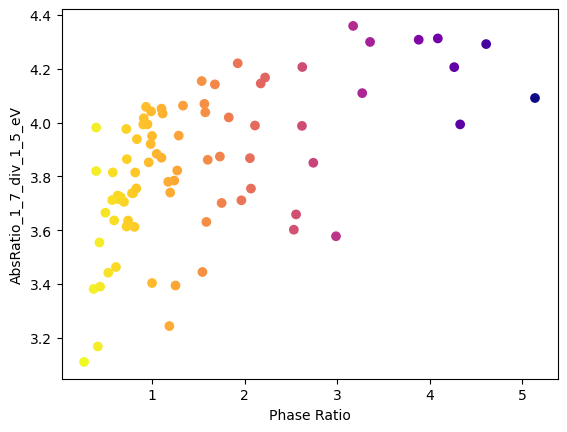

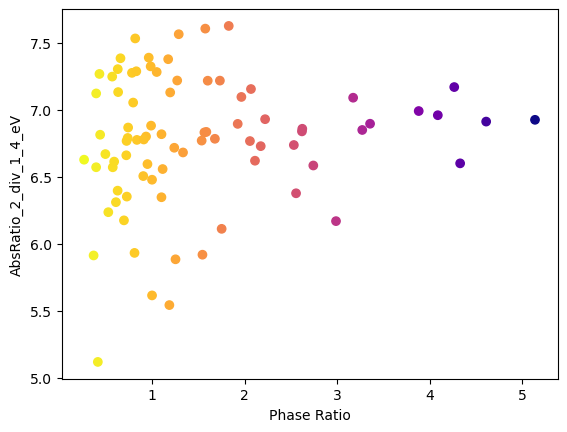

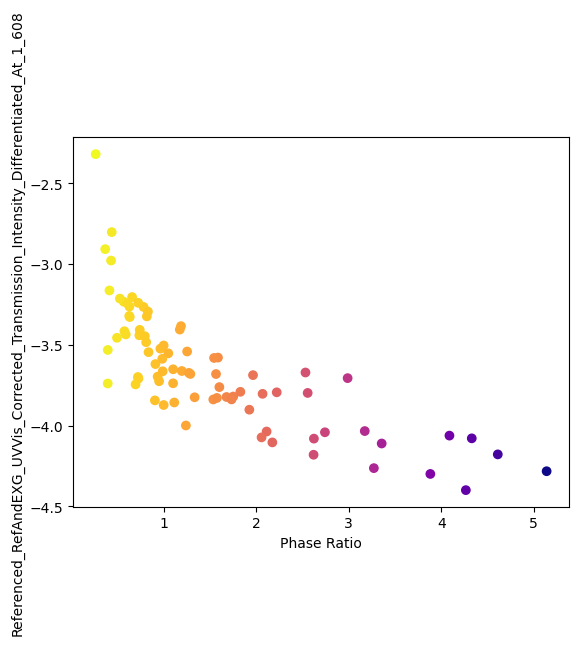

In [43]:
import matplotlib.pyplot as plt

#Use the Lorentz factor L, structure factor, multiplicity for the further presentation of the phase ratio as obtained from XRD
phaseFactors = 0.24

# Visualize each feature as a function of the phase ratio
for feature in dy.columns:
    plt.scatter(dx*phaseFactors, dy[feature], c=-dx*phaseFactors, cmap='plasma')
    plt.xlabel('Phase Ratio')
    plt.ylabel(dy[feature].name)
    plt.show()

## Build the supervised machine learning model

In [5]:
from sklearn.model_selection import train_test_split
# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dy[1:], dx[1:], test_size=0.2, random_state=42)
print(X_train.columns.to_list())

['AbsRatio_1_7_div_1_5_eV', 'AbsRatio_2_div_1_4_eV', 'Referenced_RefAndEXG_UVVis_Corrected_Transmission_Intensity_Differentiated_At_1_608']


In [38]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

# Use K Fold with shuffle true to mix data into representative chunks
kf = KFold(n_splits=5, shuffle=True, random_state=42)


# Define a pipeline that includes PolynomialFeatures and a linear regression model
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('regression', XGBRegressor(verbosity=1)),
])

# Define a grid of hyperparameters to search
# This part has been restricted to the previously identified most promising parameters to reduce computation time
param_grid = [{
    'scaler': [MinMaxScaler()],
    'regression': [XGBRegressor(verbosity=1)],
    'regression__max_depth': [3, 4],
    'regression__min_child_weight': [1],
    'regression__learning_rate': np.logspace(-2, -1, 6),
    'regression__n_estimators': [500],
    'regression__gamma': [0.7],
}]

# Create the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, n_jobs=1, scoring='neg_root_mean_squared_error', verbose=1, refit=True)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train, regression__verbose=1)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test data
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


Best Scaler: MinMaxScaler()
Best Regressor: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.7, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.039810717055349734,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=1)


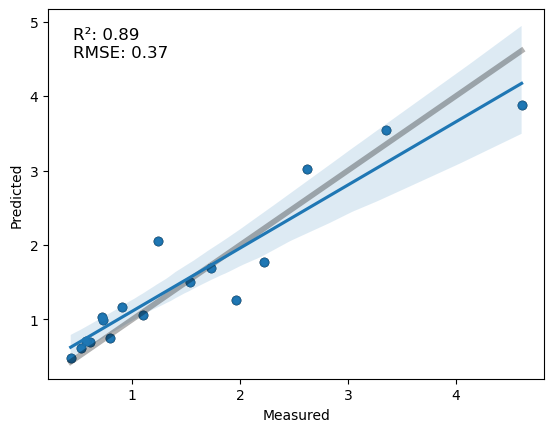

In [39]:
from sklearn.metrics import r2_score, mean_squared_error

# Calculate the R-squared score and RMSE to evaluate the best model's performance
r_squared = r2_score(y_test*phaseFactors, y_pred*phaseFactors)
mse = mean_squared_error(y_test*phaseFactors, y_pred*phaseFactors, squared=False)

print(f"Best Scaler: {best_model.named_steps['scaler']}")
print(f"Best Regressor: {best_model.named_steps['regression']}")

# Plot the measured vs. predicted values
fig, ax = plt.subplots()
ax.scatter(y_test*phaseFactors, y_pred*phaseFactors, edgecolors=(0, 0, 0))
ax.plot([y_test.min()*phaseFactors, y_test.max()*phaseFactors], [y_test.min()*phaseFactors, y_test.max()*phaseFactors], "k-", lw=4, alpha=0.3)
sns.regplot(x=y_test*phaseFactors, y=y_pred*phaseFactors, ax=ax)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
ax.text(0.05, 0.95, f'R²: {r_squared:.2f}\nRMSE: {mse:.2f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
plt.show()

[257.0, 217.0, 361.0]
['AbsRatio_1_7_div_1_5_eV', 'AbsRatio_2_div_1_4_eV', 'Referenced_RefAndEXG_UVVis_Corrected_Transmission_Intensity_Differentiated_At_1_608']


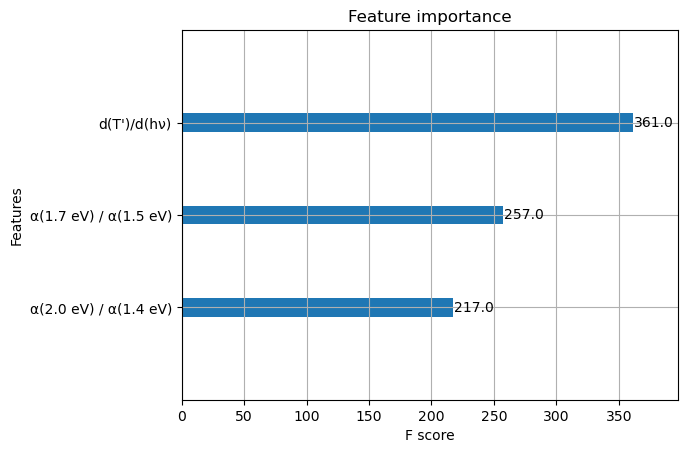

In [40]:
from xgboost import plot_importance

# Plot the importance of features
best_model.named_steps['regression'].get_booster().feature_names = ["α(1.7 eV) / α(1.5 eV)", "α(2.0 eV) / α(1.4 eV)", "d(T')/d(hν)"]
#best_model.named_steps['regression'].get_booster().feature_names = dy.columns.values.tolist()
plot_importance(best_model.named_steps['regression'], max_num_features=10)
importance = list(best_model.named_steps['regression'].get_booster().get_score(importance_type='weight').values())
print(importance)
features = dy.columns.values.tolist()
print(features)

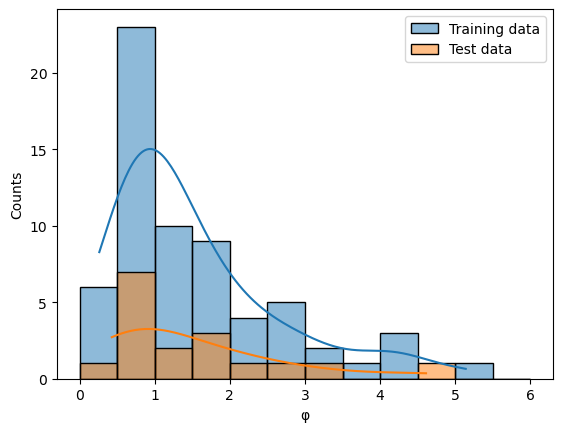

18.8% of the training data set has a phase ratio above 2.5.


In [41]:
#Show the distribution of the training and test data

bin_edges = np.linspace(0, 6, 13)

fig, ax = plt.subplots()
sns.histplot(data=y_train*phaseFactors, bins = bin_edges, kde=True, label='Training data')
sns.histplot(data=y_test*phaseFactors, bins = bin_edges, kde=True, label='Test data')
plt.xlabel('φ')
plt.ylabel('Counts')
plt.legend()
plt.show()

percentageAbove2_5 = (y_train*phaseFactors > 2.5).sum()/y_train.size

print('{:2.1%} of the training data set has a phase ratio above 2.5.'.format(percentageAbove2_5))